# Failure Mode Demonstration Notebook

A notebook to demonstrate some of the features of the Failure Mode class

Author: gavin.treseder@essentialenergy.com.au

In [1]:
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *

fm = FailureMode().set_demo()

## Single timeline
Generate a single timeline to show the state of the failure mode, its condition and the days until a task is triggered over time.

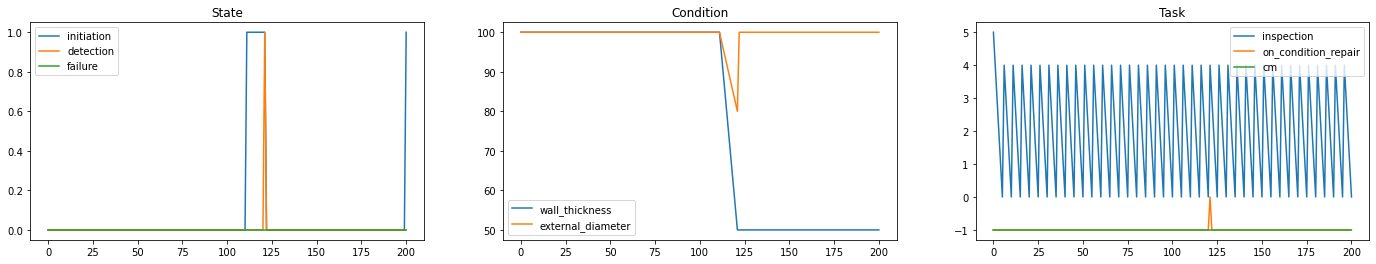

In [3]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

The simulation above assumes that the failure mode is in perfect condition while the simulation below starts with some accumulated damage.

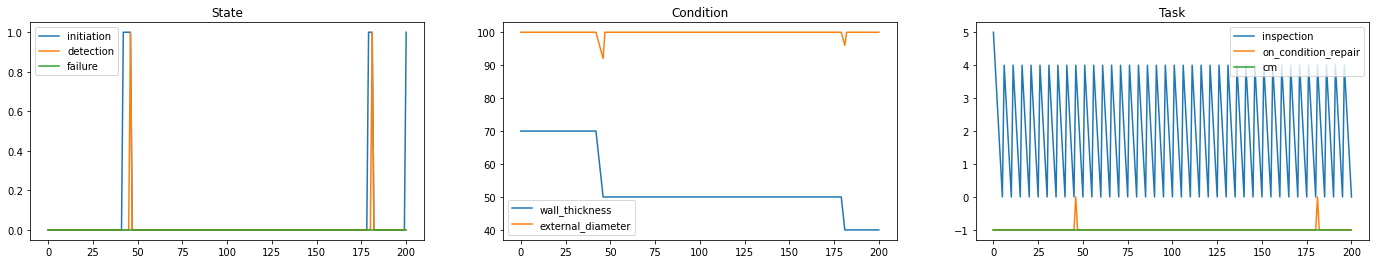

In [4]:
fm._initiated = True
fm.conditions['wall_thickness'].set_condition(70)
fm.sim_timeline(200)
fm.plot_timeline()

## Maintenance Strategy
The maintenance strategy...

In [11]:
fm = FailureMode().set_demo()

fm.conditions['wall_thickness'] = Condition(100, 0, 'linear', [-5])
fm.tasks['inspection'].p_effective = 1

fm.reset()

fm.mc_timeline(t_end=200, n_iterations=1000)

df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 1000/1000 [00:03<00:00, 262.08it/s]


In [12]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          293.992092       94.094278  157.001025  550.514559
Beta             4.081710        1.176607    2.319915    7.181451
Gamma          100.374149      100.594351   14.078389  715.633722
Log-Likelihood: -112.42878579466166


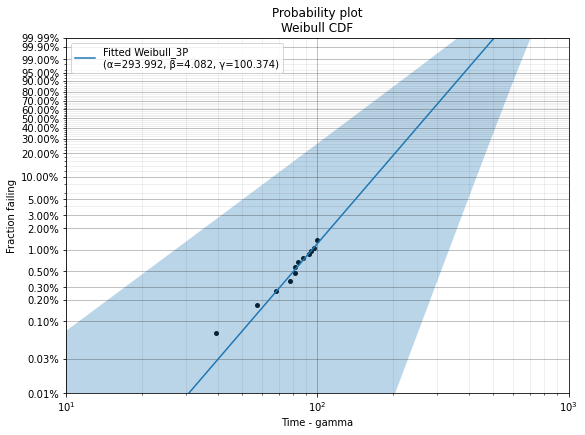

In [7]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored);

In [8]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm.expected_costs()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:01<00:00, 647.22it/s]


In [10]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [13]:
# Dists

# Impacts



# Tasks
scheduled_inspection = Inspection(t_interval=10)

scheduled_inspection.set_params(
        t_interval = 5,
        t_delay = 20,
        p_effective = 0.9,
        state_triggers = dict(),

        condition_triggers = dict(
            wall_thickness = dict(
                lower = 0,
                upper = 90,
            ),
        ),

        state_impacts = dict( 
            detection = True,
        ),

        condition_impacts = dict(
            wall_thickness = dict(
                target = None,
                reduction_factor = 0,
                method = 'reduction_factor',
                axis = 'condition',
             ),
        ),
)

# Failure Modes
early_life = FailureMode(alpha=10000, beta=0.5, gamma=0)
random = FailureMode(alpha=100, beta=1, gamma=0)
slow_aging = FailureMode(alpha=100, beta=1.5, gamma=20)
fast_aging = FailureMode(alpha=50, beta=3, gamma=20)

fm_demo = slow_aging

fm_demo.set_conditions(dict(
    wall_thickness = Condition(100, 0, 'linear', [-2]),
    external_diameter = Condition(100, 0, 'linear', [-5]),
))

fm_demo.set_tasks(dict(
    inspection = scheduled_inspection,
    #ocr = OnConditionRepair(activity='on_condition_repair').set_default(),
    cm = ImmediateMaintenance(activity='cm').set_default(),
))


True

In [14]:
fm_demo.mc_timeline(1000)

df = fm_demo.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


In [15]:
fm.tasks['ocr'].__dict__

{'name': 'unknown',
 'activity': 'on_condition_repair',
 'trigger': 'condition',
 'active': True,
 'trigger_comp': '1.1.2',
 '_package': NotImplemented,
 '_impacts_parent': NotImplemented,
 '_impacts_children': False,
 'cost': 100,
 'labour': 'trade',
 'spares': 'pole',
 'equipment': 'ewp',
 'consequence': <consequence.Consequence at 0x190675cfca0>,
 'p_effective': 1,
 'time_triggers': {},
 'state_triggers': {'detection': True},
 'condition_triggers': {'wall_thickness': {'lower': 20, 'upper': 80}},
 'time_impacts': {},
 'state_impacts': {'initiation': False, 'detection': False, 'failure': False},
 'condition_impacts': {'wall_thickness': {'target': 0,
   'method': 'reduction_factor',
   'axis': 'condition'}},
 'state': 'up',
 't_completion': [],
 '_timeline': NotImplemented,
 '_count_checked': NotImplemented,
 '_count_triggered': NotImplemented,
 '_count_completed': 0,
 'task_type': 'immediate'}

In [15]:
list(fm.timeline)

['time',
 'initiation',
 'wall_thickness',
 'external_diameter',
 'failure',
 'inspection',
 'detection',
 'on_condition_repair',
 'cm']

In [35]:
%%timeit
t_failure = []

for timeline in fm._timelines.values():
    t_failure = np.append(t_failure, np.argmax(timeline["failure"]))

# Cahnge times where no failure was observed to the max

failures = t_failure[t_failure > 0]
censored = np.full(sum(t_failure == 0), 200)

12.5 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:

t_failures = []
for timeline in fm._timelines.values():
    if not timeline['failure'].any():
        t_fail = timeline['time'][-1] + 1
    else:
        t_fail = timeline['time'][timeline['failure']][0]
    
    t_failures = t_failures.append(t_fail)

AttributeError: 'NoneType' object has no attribute 'append'

In [46]:
t_failures = []
for i in range(10)
    t_failures = t_failures.append(t_fail)